In [3]:
#tools
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper

In [4]:
api_wrapper_arxiv=ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv=ArxivQueryRun(api_wrapper=api_wrapper_arxiv,description="Query arxiv papers")
print(arxiv.name)

arxiv


In [5]:
arxiv.invoke("Attention is all you need.")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time o"

In [6]:
api_wrapper_wiki=WikipediaAPIWrapper(top_k_results=2,doc_content_chars_max=500)
wikipedia=WikipediaQueryRun(api_wrapper=api_wrapper_wiki,description="Query wiki information")
print(wikipedia.name)

wikipedia


In [7]:
wikipedia.invoke("What's the date of birth of Virat Kohli")

"Page: Career of Virat Kohli\nSummary: Virat Kohli's senior career began when he made his debut in List A cricket, playing against Services in the Ranji One-Day Trophy, but he did not have the opportunity to bat during the match. On the international stage, he has been representing India since he was included in the ODl squad for the tour of Sri Lanka. Kohli was part of the team during India won the 2011 Cricket World Cup, the 2013 ICC Champions Trophy, the 2024 ICC T20 World Cup and 2025 ICC Cham"

In [11]:
from dotenv import load_dotenv
load_dotenv()

import os

os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

In [13]:
# Tavily - It's a tool to connect LLM to internet
from langchain_tavily import TavilySearch

tavily = TavilySearch()

In [14]:
tavily.invoke("Tell me the recent news about Formula 1")

{'query': 'Tell me the recent news about Formula 1',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.newsnow.com/us/Sports/F1',
   'title': 'F1 News | Latest Formula One News - NewsNow',
   'content': 'Latest F1 news in a live feed, including breaking news, race results, driver interviews, analysis, commentary and all updates relating to Formula 1 racing.',
   'score': 0.74273956,
   'raw_content': None},
  {'url': 'https://www.motorsport.com/f1/news/',
   'title': 'The Latest Formula 1 News, Articles & F1 Results - Motorsport.com',
   'content': 'Updated F1 news and LIVE text coverage on all GP races. From practice and qualifying to the main race event. Photos, videos, results, driver stats and more.',
   'score': 0.6780931,
   'raw_content': None},
  {'url': 'https://www.formula1.com/en/latest',
   'title': 'Latest F1 News',
   'content': "Don't miss a Formula 1 moment – with the latest news, videos, standings and results. Go behind the

In [22]:
tools = [arxiv, wikipedia, tavily]

from langchain_groq import ChatGroq
ll=ChatGroq(model="llama-3.1-8b-instant")

In [23]:
ll.invoke("Tell me the 2025 IPL winner")

AIMessage(content="I don't have information on the 2025 IPL winner. My knowledge cutoff is December 2023, and the 2025 IPL season has not yet occurred. I can provide information on past IPL winners, though.", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 46, 'prompt_tokens': 43, 'total_tokens': 89, 'completion_time': 0.070452668, 'prompt_time': 0.003280207, 'queue_time': 0.034822795, 'total_time': 0.073732875}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_020e283281', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--22284890-24cb-417b-a8ec-135d28bb93a2-0', usage_metadata={'input_tokens': 43, 'output_tokens': 46, 'total_tokens': 89})

In [24]:
llm_with_tools=ll.bind_tools(tools=tools)

### Alternative: Using JSON for even more structured output


In [27]:
import json

response = llm_with_tools.invoke("What is the latest news about ChatGPT Atlas")

# Create structured output dictionary
output = {
    "content": response.content,
    "tool_calls": [],
    "response_metadata": response.response_metadata if hasattr(response, 'response_metadata') else None
}

# Add tool calls if present
if hasattr(response, 'tool_calls') and response.tool_calls:
    for tool_call in response.tool_calls:
        output["tool_calls"].append({
            "name": tool_call.get('name'),
            "id": tool_call.get('id'),
            "args": tool_call.get('args', {})
        })

# Pretty print JSON
print(json.dumps(output, indent=2, ensure_ascii=False))


{
  "content": "",
  "tool_calls": [
    {
      "name": "tavily_search",
      "id": "js4ebxeks",
      "args": {
        "query": "ChatGPT Atlas latest news",
        "search_depth": "advanced",
        "time_range": "day",
        "topic": "news"
      }
    }
  ],
  "response_metadata": {
    "token_usage": {
      "completion_tokens": 41,
      "prompt_tokens": 1905,
      "total_tokens": 1946,
      "completion_time": 0.057696343,
      "prompt_time": 0.142233523,
      "queue_time": 0.037501029,
      "total_time": 0.199929866
    },
    "model_name": "llama-3.1-8b-instant",
    "system_fingerprint": "fp_020e283281",
    "service_tier": "on_demand",
    "finish_reason": "tool_calls",
    "logprobs": null
  }
}


### When the LLM is bound with tools, the first output is usually tool call instructions, not the final answer.

### LangGraph architecture - ReAct 

####  Workflow

In [30]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages ## Reducers in langGraph

In [32]:
# State Schema
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages] # All the messages (Human messages, System messages, AI messages) are appended to the messages using REDUCERS -> add_messages


In [33]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition #Tool_conditions -> used to tell LLM if tool part is called which path i should take, and viceversa

In [48]:
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

#Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)

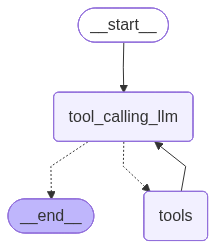

In [49]:
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [55]:
from langchain_core.messages import HumanMessage


messages=graph.invoke({"messages":HumanMessage(content="What is a AI Engineer")})
for res in messages["messages"]:
    res.pretty_print()

================================ Human Message =================================

What is a AI Engineer
================================== Ai Message ==================================
Tool Calls:
  wikipedia (00rz1stfa)
 Call ID: 00rz1stfa
  Args:
    query: AI Engineer
================================= Tool Message =================================
Name: wikipedia

Page: Artificial intelligence
Summary: Artificial intelligence (AI) is the capability of computational systems to perform tasks typically associated with human intelligence, such as learning, reasoning, problem-solving, perception, and decision-making. It is a field of research in computer science that develops and studies methods and software that enable machines to perceive their environment and use learning and intelligence to take actions that maximize their chances of achieving defined goal
================================== Ai Message ==================================
Tool Calls:
  wikipedia (5mhzv9xmg)
 Call ID: 5m

Why This Works

This happens because your graph loops:

LLM → Tools → LLM → Tools → LLM → END


This feedback-loop enables:

self-correction

relevance refinement

multiple query attempts

behavior similar to ChatGPT with Web Search

Without the loop, the model would have stopped after the first retrieval — producing a weaker answer.

In [60]:
import json

print(json.dumps([m.dict() for m in messages["messages"]], indent=2))


[
  {
    "content": "What is a AI Engineer",
    "additional_kwargs": {},
    "response_metadata": {},
    "type": "human",
    "name": null,
    "id": "7d6e92d9-0d41-42df-adac-392c0c362cad",
    "example": false
  },
  {
    "content": "",
    "additional_kwargs": {
      "tool_calls": [
        {
          "id": "00rz1stfa",
          "function": {
            "arguments": "{\"query\":\"AI Engineer\"}",
            "name": "wikipedia"
          },
          "type": "function"
        }
      ]
    },
    "response_metadata": {
      "token_usage": {
        "completion_tokens": 288,
        "prompt_tokens": 1900,
        "total_tokens": 2188,
        "completion_time": 0.410548833,
        "prompt_time": 0.105735066,
        "queue_time": 0.085814618,
        "total_time": 0.516283899
      },
      "model_name": "llama-3.1-8b-instant",
      "system_fingerprint": "fp_75db6866d3",
      "service_tier": "on_demand",
      "finish_reason": "tool_calls",
      "logprobs": null
    },
 

/var/folders/23/cj_6f1mj17b9y2stj9wvt8d40000gn/T/ipykernel_41777/648236364.py:3: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  print(json.dumps([m.dict() for m in messages["messages"]], indent=2))


In [58]:
tool_steps = [m for m in messages["messages"] if hasattr(m, "tool_calls")]
for step in tool_steps:
    step.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  wikipedia (00rz1stfa)
 Call ID: 00rz1stfa
  Args:
    query: AI Engineer
================================== Ai Message ==================================
Tool Calls:
  wikipedia (5mhzv9xmg)
 Call ID: 5mhzv9xmg
  Args:
    query: AI Engineering
================================== Ai Message ==================================

An AI Engineer is a professional who applies engineering principles and methodologies to design, develop, and deploy AI systems. They are responsible for creating scalable, efficient, and reliable AI-based solutions that can be used in various industries such as healthcare, finance, and autonomous systems.


### Doubt
Can we see why the LLM decided to call the tool again?
Can we see the internal reasoning / the “thought process” between:

First tool result →

Model evaluating →

Second tool query refinement?

### Answer

No — the internal reasoning step is not exposed by design.

This is the model’s private reasoning (a.k.a. chain-of-thought).
Modern LLM APIs do not return the inner reasoning trace, only the final actionable message (e.g., tool call request or natural-language output).

This is intentional and part of the widely adopted AI Safety & Alignment policy.

In [61]:
messages=graph.invoke({"messages":HumanMessage(content="Hi i'm Sumanth Konjeti")})
for res in messages["messages"]:
    res.pretty_print()

================================ Human Message =================================

Hi i'm Sumanth Konjeti
================================== Ai Message ==================================
Tool Calls:
  wikipedia (4rcjveyxx)
 Call ID: 4rcjveyxx
  Args:
    query: Sumanth Konjeti
================================= Tool Message =================================
Name: wikipedia

No good Wikipedia Search Result was found
================================== Ai Message ==================================
Tool Calls:
  tavily_search (fne1yg9dv)
 Call ID: fne1yg9dv
  Args:
    end_date: None
    exclude_domains: None
    include_domains: None
    include_favicon: None
    include_images: None
    query: Sumanth Konjeti
    search_depth: advanced
    start_date: None
    time_range: None
    topic: general
================================= Tool Message =================================
Name: tavily_search

{"query": "Sumanth Konjeti", "follow_up_questions": null, "answer": null, "images": [], "result